__Volatility__

Asset price volatility is central to derivatives pricing. It is defined as measure of price variability over certain period of time. In essence, it describes standard deviation of returns. There are different types of volatility: Historical, Implied, Forward. In most cases, we assume volatility to be constant, which is clearly not true and numerous studies have been dedicated to estimate this variable, both in academia and industry.

Volatility estimation by statistical means assume equal weights to all returns measured over the period. We know that over 1-day, the mean return is small as compared to standard deviation.

If we consider a simple \( m \)-period moving average, where \( \sigma_n \) is the volatility of return on day \( n \), then with \( \bar{u} \approx 0 \), we have

$$
\sigma^2_n = \frac{1}{m} \sum_{i=1}^{m} u^2_{n-i}
$$

where, \( u \) is the return and \( \sigma^2 \) is the variance.

However, any large return within this \( n \)-period will elevate the volatility until it drops out of the sample. Further, we observe volatility is mean-reverting and tends to vary around a long-term mean. To address this effect, we adopt the following weighting scheme:

$$
\sigma^2_n = \omega + \sum_{i=1}^{m} \alpha_i u^2_{n-i}$$

where, \( \omega = \gamma \bar{\sigma}^2 \) and the weights must sum to 1.

This is known as the Autoregressive Conditional Heteroscedastic (ARCH) model.


__ARCH__

Autoregressive models are a statistical technique involving a regression of lagged values where the model suggests that past values can help forecast future values of the same variable. Within the model, a time series is the dependent variable and lagged values are the independent variables.

The ARCH model, was originally developed by Robert Engle in 1982 to measure the dynamics of inflation uncertainty. Conditional heteroskedasticity refers to the notion that the next period’s volatility is conditional on the volatility in the current period as well as to the time varying nature of volatility. However, given the volatility dynamics, this model fail to fully capture the persistence of volatility.

__GARCH__

To address the shortcoming, ARCH has been extended to a generalised framework where we add volatility as a forecasting feature by adding previous variance. This method is popularly known as Generalized ARCH or GARCH model.



$$
\sigma^2_n = \omega + \sum_{i=1}^{p} \alpha_i u^2_{n-i} + \sum_{i=1}^{q} \beta_i \sigma^2_{n-i}
$$

where,  p
  and  q
  are lag length.

GARCH(1,1) is then represented as,

$$
\sigma^2_n = \omega + \alpha u^2_{n-1} + \beta \sigma^2_{n-1}
$$

where,  α+β<1
  and  γ+α+β=1
  as weight applied to long term variance cannot be negative.

The GARCH model is a way of specifying the dependence of the time varying nature of volatility. The model incorporates changes in the fluctuations in volatility and tracks the persistence of volatility as it fluctuates around its long-term average and are exponentially weighted.

To model GARCH or the conditional volatility, we need to derive  ω
 ,  α
 ,  β
  by maximizing the likelihood function.

In [3]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 16, 8

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load locally stored data
df = pd.read_csv('data/vol.csv', parse_dates=True, index_col=0, dayfirst=True)

# Check first 5 values 
df.head()

,VIX,S&P 500
DATE,,
1990-01-02,18.19,386.162
1990-01-03,18.19,385.171
1990-01-04,19.22,382.018
1990-01-05,20.11,378.299
1990-01-08,20.26,380.039


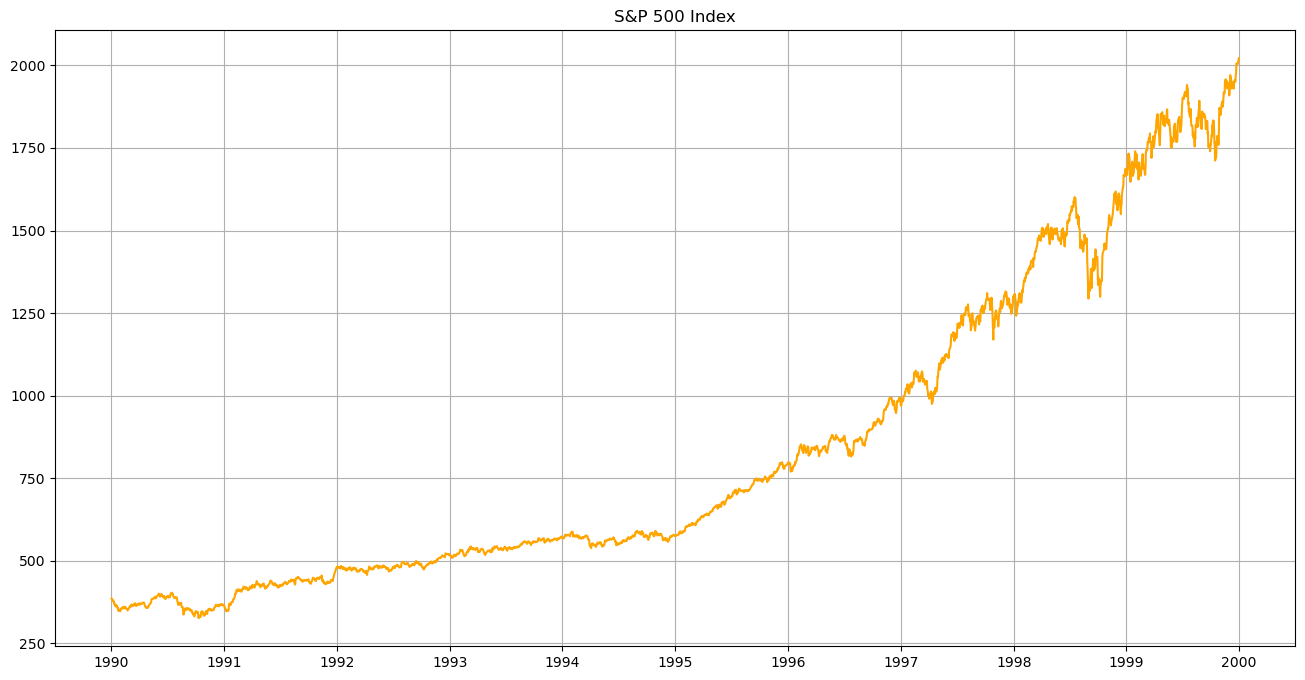

In [5]:
# Visualize FTSE 100 Index Price
plt.plot(df['S&P 500'], color='orange')
plt.title('S&P 500 Index')
plt.grid(True)

__Calculate Log Returns__

In [6]:
# Calculate daily returns
returns = np.log(df['S&P 500']).diff().fillna(0)

In [7]:
returns

DATE
1990-01-02    0.000000
1990-01-03   -0.002570
1990-01-04   -0.008220
1990-01-05   -0.009783
1990-01-08    0.004589
                ...   
1999-12-27   -0.000851
1999-12-28    0.000386
1999-12-29    0.004103
1999-12-30    0.000707
1999-12-31    0.003267
Name: S&P 500, Length: 2528, dtype: float64

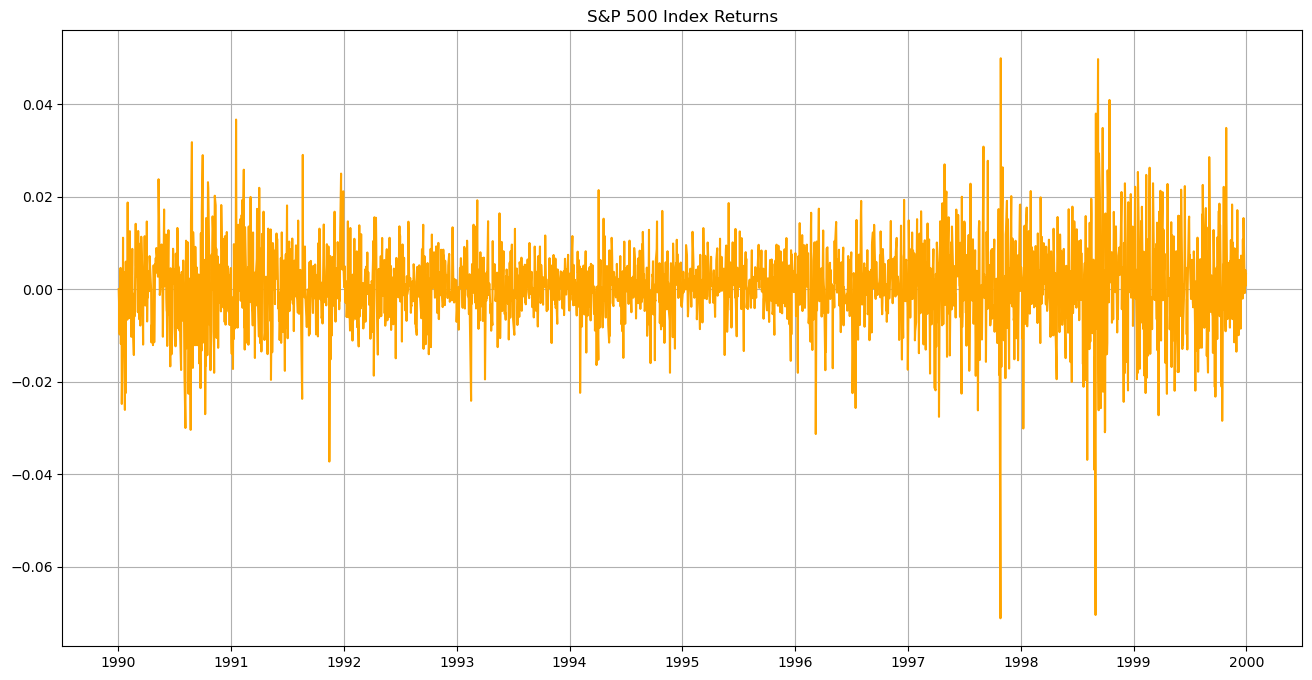

In [8]:
# Visualize FTSE 100 Index daily returns
plt.plot(returns, color='orange')
plt.title('S&P 500 Index Returns')
plt.grid(True)

__Numerical Optimization__

We will use Numerical optimization to maximize the likelihood estimation. Numerical optimization is typically implemented to find the minimum of a function rather than the maximum and the function to be minimize is called an objective function. For maximum likelihood estimation, we simply define a negative log likelihood as our objective function.

__GARCH__

Advantage of using a GARCH method when compared to EWMA is the inclusion of long term variance or volatility as a forecasting feature.

In [9]:
# GARCH(1,1) function
def garch(omega, alpha, beta, ret):
    
    length = len(ret)
    
    var = []
    for i in range(length):
        if i==0:
            var.append(omega/np.abs(1-alpha-beta))
        else:
            var.append(omega + alpha * ret[i-1]**2 + beta * var[i-1])
            
    return np.array(var)

In [10]:
garch(0.00000790570,0.1,0.8,returns)[:3]


array([7.90570000e-05, 7.11513000e-05, 6.54870136e-05])

__Maximum Likelihood Estimation__

Maximum Likeihood Estimation (MLE) is a statistical method used for fitting the data to a model. When using MLE, we first assume a distribution (ie., a parametric model) and then try to determine the model parameters. To estimate GARCH(1,1) parameters, we assume distribution of returns conditional on variance are normally distributed.

$$
\sum_{i=1}^{n} \log \left[ \frac{1}{\sqrt{2\pi \sigma^2_i}} e^{-\frac{(u_i - \bar{u})^2}{2\sigma^2_i}} \right]
$$

to derive  ω
 ,  α
  and  β
 .

In [11]:
# Log likelihood function
def likelihood(params, ret):
    
    length = len(ret)
    omega = params[0]
    alpha = params[1]
    beta = params[2]
    
    variance = garch(omega, alpha, beta, ret)
    
    llh = []
    for i in range(length):
        llh.append(np.log(norm.pdf(ret[i], 0, np.sqrt(variance[i]))))
    
    return -np.sum(np.array(llh))

In [12]:
likelihood((0.00000790570, 0.1, 0.8),returns)


-8540.382225783564

__Optimization__

Next, to optimize the GARCH parameters, we will use the minimize function from scipy optimization module. The objective function here is a function returning maximum log likelihood and the target variables are GARCH parameters.

Further, we use the Nelder–Mead method also known as downhill simplex method which is a commonly applied to numerical method to find the minimum or maximum of an objective function in a multidimensional space. The simplex algorithm is probably the simplest way to minimize a fairly well-behaved function. It requires only function evaluations and is a good choice for simple minimization problems. The downside to this method is it may take longer to find the minimum as it does not use any gradient evaluations.

In [13]:
# Specify optimization input
param = ['omega', 'alpha', 'beta']
initial_values = (0.00000790570, 0.1,0.8)

In [14]:
res = minimize(likelihood, initial_values, args = returns, 
                   method='Nelder-Mead', options={'disp':False})

In [15]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -8596.645903355027
             x: [ 4.654e-07  4.884e-02  9.465e-01]
           nit: 77
          nfev: 135
 final_simplex: (array([[ 4.654e-07,  4.884e-02,  9.465e-01],
                       [ 4.651e-07,  4.876e-02,  9.465e-01],
                       [ 4.664e-07,  4.884e-02,  9.465e-01],
                       [ 4.673e-07,  4.890e-02,  9.464e-01]]), array([-8.597e+03, -8.597e+03, -8.597e+03, -8.597e+03]))

In [16]:
res['x']

array([4.65438215e-07, 4.88435228e-02, 9.46474229e-01])

In [17]:
# GARCH parameters
dict(zip(param,np.around(res['x']*100,4)))

{'omega': 0.0, 'alpha': 4.8844, 'beta': 94.6474}

In [18]:
# Parameters
omega = res['x'][0] 
alpha = res['x'][1]
beta = res['x'][2]

# Variance
var = garch(res['x'][0],res['x'][1],res['x'][2],returns)

# Annualised conditional volatility
ann_vol = np.sqrt(var*252) * 100
ann_vol

array([15.82720004, 15.43583318, 15.08301156, ..., 14.05045667,
       13.78742288, 13.45929364])

__Visualize Volatility__

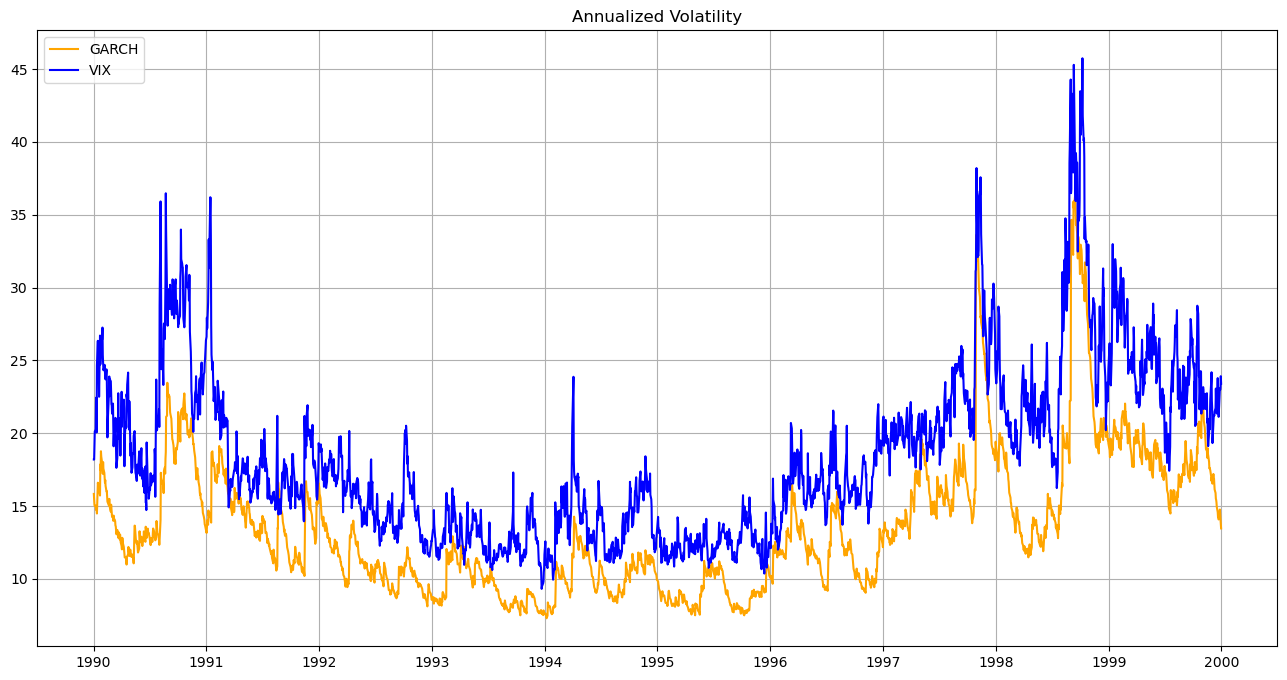

In [19]:
# Visualise GARCH volatility and VIX
plt.title('Annualized Volatility')
plt.plot(returns.index, ann_vol, color='orange', label='GARCH')
plt.plot(returns.index, df['VIX'], color='blue', label = 'VIX')
plt.legend(loc=2)
plt.grid(True)

__N-day Forecast__

Extending the GARCH(1,1) model to forecast future volatility, we can derive the n-days ahead forecast using the following equation.

$$
E[\sigma^2_{n+k}] = \bar{\sigma}^2 + (\alpha + \beta)^k \cdot (\sigma^2_n - \bar{\sigma}^2)$$\]


where,  \bar{\sigma}^2
  is the long run variance and  α
  and  β
  are GARCH parameters.

We know that volatility has the tendency to revert to its long run range. And,  α+β<1
  in GARCH(1,1) and hence when k gets larger, the second term gets smaller and the forecast tends towards the long term variance.

In [20]:
# Calculate N-day forecast
longrun_variance = omega/(1-alpha-beta)
 
fvar = []
for i in range(1,732):    
    fvar.append(longrun_variance + (alpha+beta)**i * (var[-1] - longrun_variance))

var = np.array(fvar)

In [21]:
# Verify first 10 values
var[:10]

array([7.20147969e-05, 7.21430440e-05, 7.22706906e-05, 7.23977395e-05,
       7.25241936e-05, 7.26500556e-05, 7.27753282e-05, 7.29000143e-05,
       7.30241166e-05, 7.31476378e-05])

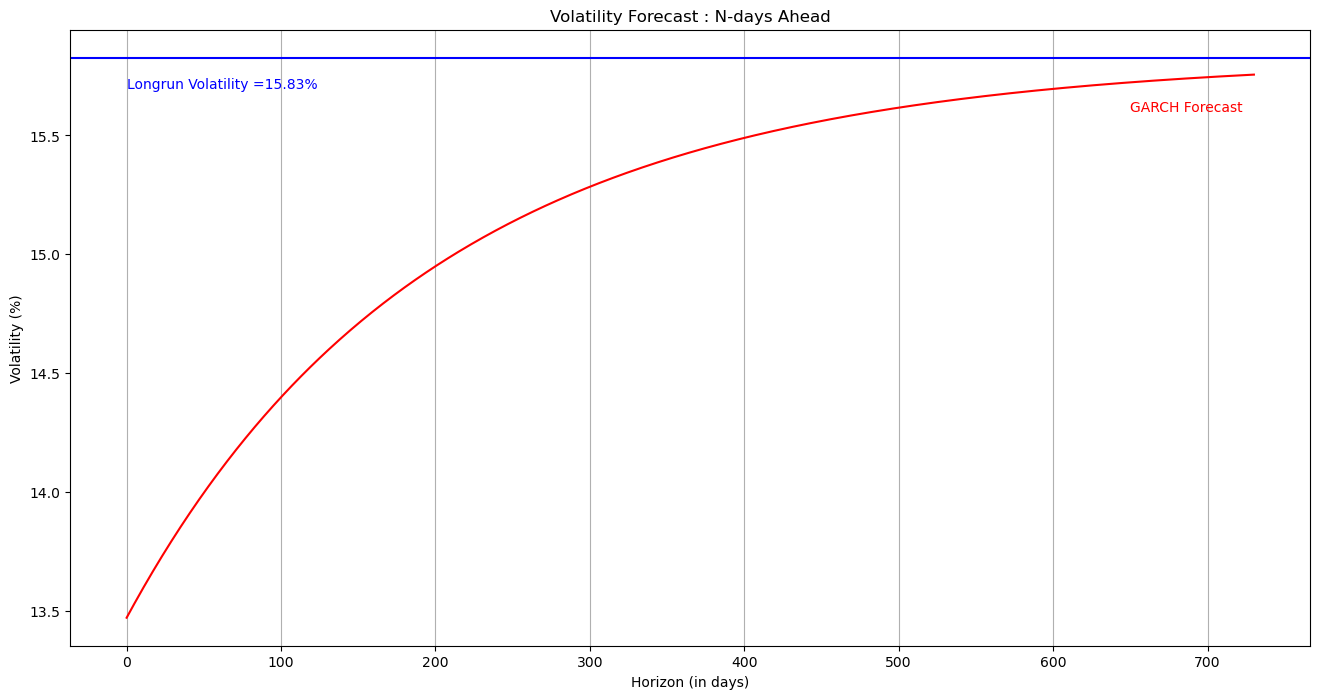

In [22]:
# Plot volatility forecast over different time horizon
plt.axhline(y=np.sqrt(longrun_variance*252)*100, color='blue')
plt.plot(np.sqrt(var*252)*100, color='red')

plt.xlabel('Horizon (in days)')
plt.ylabel('Volatility (%)')

plt.annotate('GARCH Forecast', xy=(650,15.60), color='red')
plt.annotate('Longrun Volatility =' + str(np.around(np.sqrt(longrun_variance*252)*100,2)) + '%', 
             xy=(0,15.70), color='blue')

plt.title('Volatility Forecast : N-days Ahead')
plt.grid(axis='x')

__ARCH Toolbox__

ARCH is one of the popular tools used for financial econometrics, written in Python - with Cython and/or Numba used to improve performance. We will now use arch_model to fit our GARCH model using this package

In [25]:
# Import arch library
from arch import arch_model

In [26]:
# Mean zero
g1 = arch_model(returns, vol='GARCH', mean='Zero', p=1, o=0, q=1, dist='Normal')
model = g1.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2050.4278417435034
Iteration:      2,   Func. Count:     12,   Neg. LLF: -8586.063261624044
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8586.0632607848
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 2


In [27]:
# Model output
print(model)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                S&P 500   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8586.06
Distribution:                  Normal   AIC:                          -17166.1
Method:            Maximum Likelihood   BIC:                          -17148.6
                                        No. Observations:                 2528
Date:                Tue, Sep 10 2024   Df Residuals:                     2528
Time:                        08:02:50   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.8795e-06  5.793e-10   3244.655      0.000 [1.

In [28]:
# Model params
model.params

omega       0.000002
alpha[1]    0.100331
beta[1]     0.880044
Name: params, dtype: float64

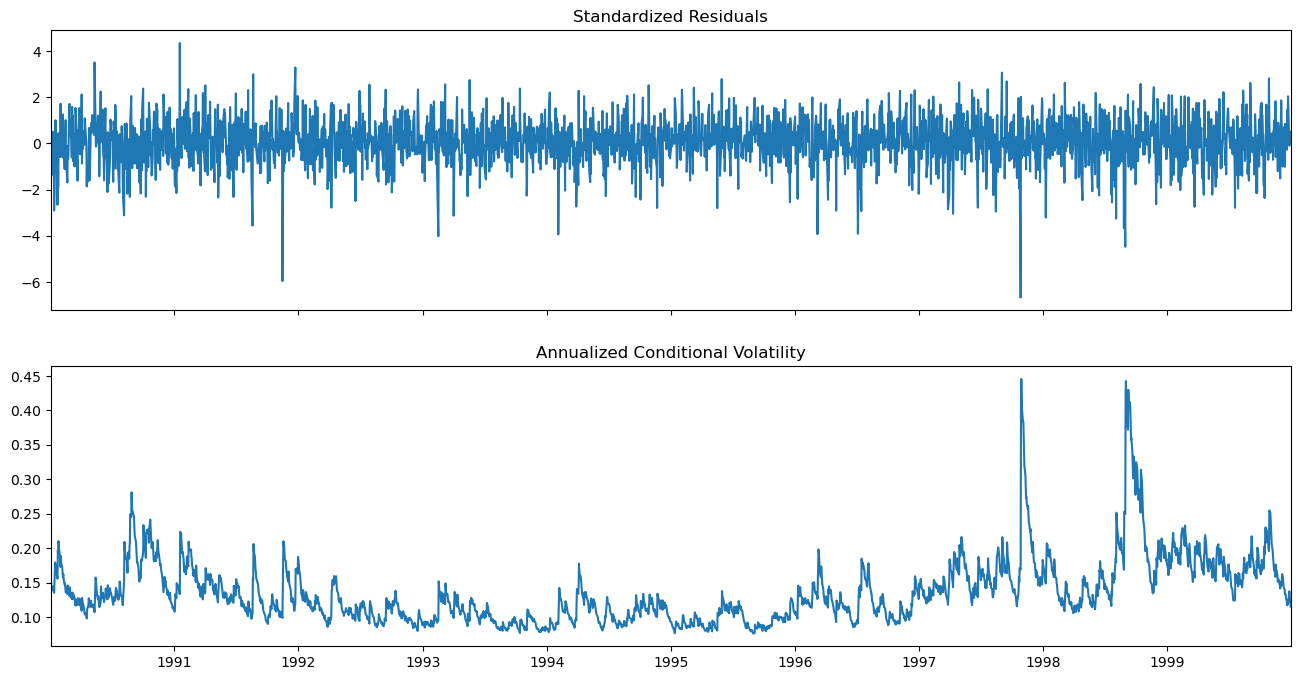

In [29]:
# Plot annualised vol
fig = model.plot(annualize='D')

In [30]:
model.conditional_volatility*np.sqrt(252)

DATE
1990-01-02    0.158418
1990-01-03    0.150198
1990-01-04    0.143157
1990-01-05    0.142188
1990-01-08    0.143825
                ...   
1999-12-27    0.137740
1999-12-28    0.131104
1999-12-29    0.124915
1999-12-30    0.120960
1999-12-31    0.115596
Name: cond_vol, Length: 2528, dtype: float64

In [31]:
# Constant mean
g2 = arch_model(returns, vol='GARCH', mean='Constant', p=1, o=0, q=1, dist='Normal')
# Model output
model2 = g2.fit(disp='off')
print(model2)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                S&P 500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8598.87
Distribution:                  Normal   AIC:                          -17189.7
Method:            Maximum Likelihood   BIC:                          -17166.4
                                        No. Observations:                 2528
Date:                Tue, Sep 10 2024   Df Residuals:                     2527
Time:                        08:04:01   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.4043e-04  8.991e-06     82.350      0.000 [7.

In [32]:
# Forecast for next 60 days
model_forecast = model.forecast(horizon=60)

In [33]:
# Subsume forecast values into a dataframe
forecast_df = pd.DataFrame(np.sqrt(model_forecast.variance.dropna().T *252)*100)
forecast_df.columns = ['Cond_Vol']
forecast_df.head()

,Cond_Vol
h.01,11.181697
h.02,11.283308
h.03,11.382044
h.04,11.478018
h.05,11.571336


In [34]:
# long run variance from model forecast
lrv = model.params[0]/(1-model.params[1]-model.params[2])

# long run variance
np.sqrt(lrv*252)*100

15.535226533928753

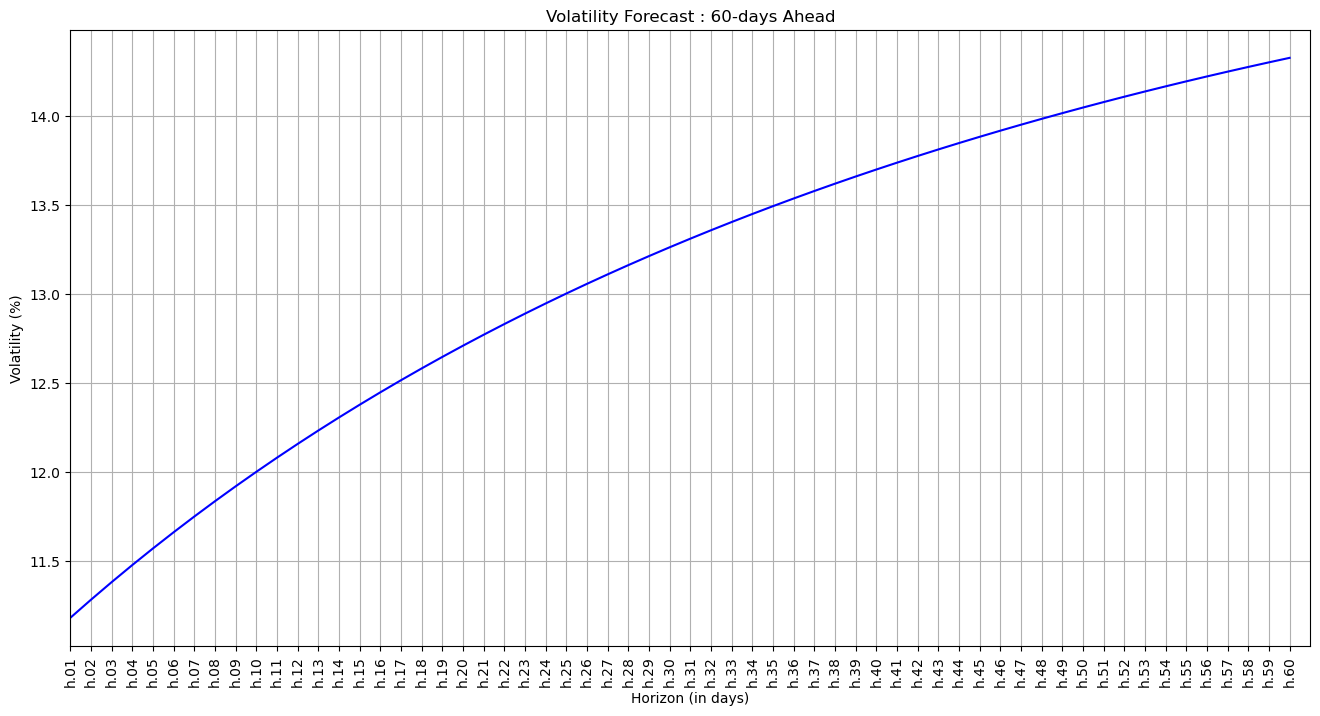

In [35]:
# Plot volatility forecast over a 60-day horizon
plt.plot(forecast_df, color='blue')
plt.xlim(0,60)
plt.xticks(rotation=90)
plt.xlabel('Horizon (in days)')
plt.ylabel('Volatility (%)')
plt.title('Volatility Forecast : 60-days Ahead');
plt.grid(True)